In [1]:
from custom_torch_dataset import SwipeDataset
import os
from torch.utils.data import random_split

dataset_path = os.path.join(os.getcwd(), "dataset")

data = SwipeDataset(data_dir=dataset_path,
                    batch=False)

train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])

In [2]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """
    :param batch: List of tuples (input, word, word_tensor)
                  - input: (T, 6)
                  - word: a string of characters
                  - word_tensor: encoded word as indicies with 0 as the blank

    """
    # Sort batch by sequence length (descending order)
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)
    inputs, words, targets = zip(*batch)
    input_lengths = torch.LongTensor([x.shape[0] for x in inputs])  # store the lengths of inputs

    target_lengths = torch.LongTensor([len(x) for x in words])
    targets = torch.cat(targets)    # concatenate all the targets

    padded_inputs = pad_sequence(inputs, batch_first=True)  # pad inputs to max length with zeros   (B, T, 6)

    return padded_inputs, targets, input_lengths, target_lengths, words

In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, collate_fn=collate_fn)

dataloaders = {"train": train_loader,
               "val": val_loader}

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

class SwipeToTextCTC(nn.Module):
    def __init__(self, input_size=6, conv_channels=32, hidden_size=128,
                 num_layers=2, output_size=27, bidirectional=True,
                 dropout=0.1):
        super(SwipeToTextCTC, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=conv_channels, kernel_size=5, padding=2, stride=1),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )

        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=False,
            bidirectional=bidirectional,
            dropout=dropout
        )

        lstm_out_dim = 2 * hidden_size if bidirectional else hidden_size
        self.layer_norm = nn.LayerNorm(lstm_out_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(lstm_out_dim, output_size)

    def forward(self, x, input_lengths):
        """
        x: (B, T, 6) = (batch, sequence length, feature dim)
        output: (T, B, output_size)
        """
        x = x.permute(0, 2, 1)         # (B, 6, T)
        x = self.conv(x)               # (B, conv_channels, T)
        x = x.permute(2, 0, 1)         # (T, B, conv_channels)

        lstm_in = pack_padded_sequence(x, input_lengths.cpu(), batch_first=False)
        lstm_outputs, _ = self.lstm(lstm_in)   
        lstm_out = pad_packed_sequence(lstm_outputs, batch_first=False)[0]  

        lstm_out = self.layer_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)     # (T, B, output_size)
        
        return F.log_softmax(logits, dim=-1)

In [5]:
t_model = SwipeToTextCTC(input_size=6,
                         conv_channels=32,
                         hidden_size=64,
                         num_layers=2,
                         output_size=27,
                         bidirectional=True,
                         dropout=0.1).to(device)

t_inputs, t_targets, t_input_lengths, t_target_lengths, t_words = next(iter(train_loader))
t_output = t_model(t_inputs.to(device), t_input_lengths)

In [6]:
import torch
import time
from tempfile import TemporaryDirectory
import os
import matplotlib.pyplot as plt

class EarlyStopper:
    def __init__(self, patience=15, min_delta=0.05):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 0
            return False  # No early stopping
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
            return False

def CTCtrain(model, dataloaders, set_lengths, optimiser, num_epochs = 5, scheduler = None, patience = 15, min_delta = 0.05):
    criterion = torch.nn.CTCLoss(blank=0, zero_infinity=True)

    train_loss = []
    val_loss = []

    early_stopper = EarlyStopper(patience=patience, min_delta = min_delta)
    stop = False

    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        lowest_loss = float("Inf")
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, targets, input_lengths, target_lengths, words in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    target_lengths = target_lengths.to(device)

                    # zero the parameter gradients
                    optimiser.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs, input_lengths)
                        loss = criterion(outputs, targets, input_lengths.to(device), target_lengths)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
                            loss.backward()
                            optimiser.step()

                    # statistics
                    running_loss += loss.item() * len(target_lengths)  # multiply by batch size
                if phase == 'train' and scheduler is not None:
                    scheduler.step(loss)

                epoch_loss = running_loss / set_lengths[phase]

                print(f'{phase} Loss: {epoch_loss:.4f}')
                
                if phase == "train":
                    train_loss.append(epoch_loss)
                else:
                    val_loss.append(epoch_loss)
                
                # early stop based on validation loss
                if phase == 'val':
                    stop = early_stopper.early_stop(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_loss < lowest_loss:
                    lowest_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)
                
            if stop:
                break
            
            time_elapsed = time.time() - since
            print(f"Time Elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Lowest Loss: {lowest_loss:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

        plt.plot(train_loss, label="Training Loss")
        plt.plot(val_loss, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.legend()
        plt.show
    return model

Epoch 1/100
----------
train Loss: 3.7561
val Loss: 3.2191
Time Elapsed: 0m 20s

Epoch 2/100
----------
train Loss: 3.1629
val Loss: 3.0903
Time Elapsed: 0m 38s

Epoch 3/100
----------
train Loss: 3.0304
val Loss: 3.0327
Time Elapsed: 0m 57s

Epoch 4/100
----------
train Loss: 2.9428
val Loss: 2.9549
Time Elapsed: 1m 15s

Epoch 5/100
----------
train Loss: 2.8754
val Loss: 2.8485
Time Elapsed: 1m 31s

Epoch 6/100
----------
train Loss: 2.8040
val Loss: 2.8259
Time Elapsed: 1m 48s

Epoch 7/100
----------
train Loss: 2.7240
val Loss: 2.6840
Time Elapsed: 2m 5s

Epoch 8/100
----------
train Loss: 2.6135
val Loss: 2.5123
Time Elapsed: 2m 21s

Epoch 9/100
----------
train Loss: 2.4910
val Loss: 2.4099
Time Elapsed: 2m 36s

Epoch 10/100
----------
train Loss: 2.3752
val Loss: 2.3006
Time Elapsed: 2m 52s

Epoch 11/100
----------
train Loss: 2.2639
val Loss: 2.2089
Time Elapsed: 3m 8s

Epoch 12/100
----------
train Loss: 2.1678
val Loss: 2.1376
Time Elapsed: 3m 24s

Epoch 13/100
----------
tra

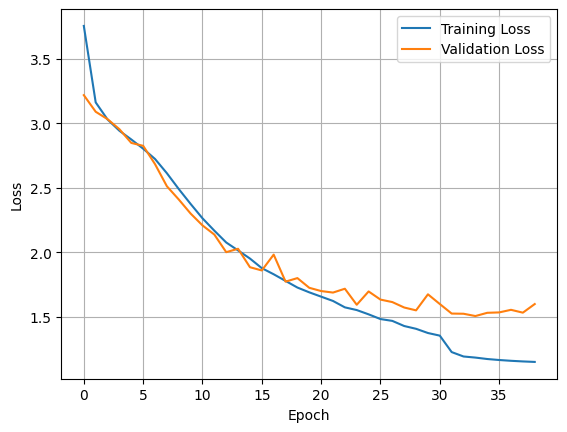

In [7]:
t_model = SwipeToTextCTC(input_size=6,
                         conv_channels=32,
                         hidden_size=128,
                         num_layers=2,
                         output_size=27,
                         bidirectional=True,
                         dropout=0.2).to(device)

set_lengths = {"train":len(train_set),
               "val":len(val_set)}

optimiser = torch.optim.AdamW(t_model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=5, factor=0.1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser,step_size=10, gamma=0.1)
t_model = CTCtrain(t_model, dataloaders,set_lengths, optimiser, num_epochs=100, scheduler=scheduler, patience = 5, min_delta = 0.01)

In [19]:
import os
model_file = "conv_k5.pt"
save_path = os.path.join(os.getcwd(), "models", model_file)
torch.save(t_model, save_path)

In [20]:
import os
import torch
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model_file = "conv_k5.pt"
save_path = os.path.join(os.getcwd(), "models", model_file)

t_model = torch.load(save_path, weights_only=False)

In [21]:
def test_model(model, test_data, datapoints):
    criterion = torch.nn.CTCLoss(blank=0, zero_infinity=True)

    model_outputs = []
    ground_truth = []
    # set the model into evaluation mode
    model.eval()

    running_loss = 0.0

    # Iterate over data.
    for inputs, targets, input_lengths, target_lengths, words in test_data:
        inputs = inputs.to(device)
        targets = targets.to(device)

        input_lengths = input_lengths.to(device)
        target_lengths = target_lengths.to(device)

        outputs = model(inputs, input_lengths)
        model_outputs.append(outputs.cpu())
        ground_truth.append(words)
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        
        running_loss += loss * len(target_lengths)  # multiply by batch size

    avg_loss = running_loss / datapoints    # average over the entire test set

    print(f"Average test loss: {avg_loss}")

    return model_outputs, ground_truth

In [22]:
logits, truth = test_model(t_model, test_loader, len(test_set))

Average test loss: 1.3229529857635498


In [14]:
vocabulary = {'_': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8,
              'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16,
              'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24,
              'y': 25, 'z': 26}
reversed_vocab = {k: u for u, k in vocabulary.items()}

In [15]:
import torch
import torch.nn.functional as F
import heapq

def beam_search(logits, ground_truth, beam_width=3):
    """
    Decodes a tensor of logits using beam search, adapted for the provided input structure.

    Args:
        logits (torch.Tensor): A tensor of logits with shape (sequence_length, batch_size, vocab_size).
        ground_truth (list): A list of ground truth words (not directly used in beam search but included for consistency).
        reversed_vocab (dict): A dictionary mapping vocabulary indices to characters.
        beam_width (int): The width of the beam.

    Returns:
        list: A list of decoded strings, one for each sequence in the batch.
    """
    decoded_words = []
    for batch, _ in zip(logits, ground_truth):  # ground_truth is not used in the beam search.
        batched_results = []

        for b in range(batch.shape[1]):
            initial_beam = [([(0.0, "")], 0.0)]
            final_beams = []

            for t in range(batch.shape[0]):
                new_beam = []
                for seq, total_log_prob in initial_beam:
                    timestep_logits = batch[t, b, :]

                    topk_probs, topk_indices = torch.topk(timestep_logits, beam_width)

                    for i in range(beam_width):
                        char_index = topk_indices[i].item()
                        char = reversed_vocab.get(char_index, '_')
                        new_seq = seq + [(topk_probs[i].item(), char)]
                        new_total_log_prob = total_log_prob + topk_probs[i].item()
                        new_beam.append((new_seq, new_total_log_prob))

                initial_beam = heapq.nlargest(beam_width, new_beam, key=lambda x: x[1])

            best_sequence, _ = max(initial_beam, key=lambda x: x[1])
            decoded_word = "".join([char for log_prob, char in best_sequence[1:] if char != "_"])
            batched_results.append(decoded_word)

        decoded_words.append(batched_results)

    return decoded_words


In [16]:
beam_words = beam_search(logits, truth)

In [19]:
len(beam_words)

17

In [17]:
def evaluate(predictions, truth):
    exact_match = 0
    length_match = 0
    same_first = 0
    total = 0
    
    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            pred = predictions[i][j]
            ground = truth[i][j]
            total += 1

            if pred == ground:
                exact_match += 1
            
            if len(pred) == len(ground):
                length_match += 1
            
            if pred[0] == ground[0]:
                same_first += 1
    

    EM = exact_match / total
    LM = length_match / total
    FM = same_first / total

    print(f"Exact Match: {EM}")
    print(f"Correct Length: {LM}")
    print(f"Correct First Letter: {FM}")



In [18]:
evaluate(beam_words, truth)

Exact Match: 0.21489161168708765
Correct Length: 0.3892554194156456
Correct First Letter: 0.67813383600377
